# 결정트리, 랜덤 포레스트, 부스팅

In [1]:
## 환경설정

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 맥에서 레티나 디스플레이 사용 설정
%config InlineBackend.figure_format = 'retina'

# 그림 크기와 폰트 설정
matplotlib.rcParams['figure.figsize'] = (6,4)
plt.rc('font', size=13)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.metrics import mean_absolute_percentage_error,r2_score               

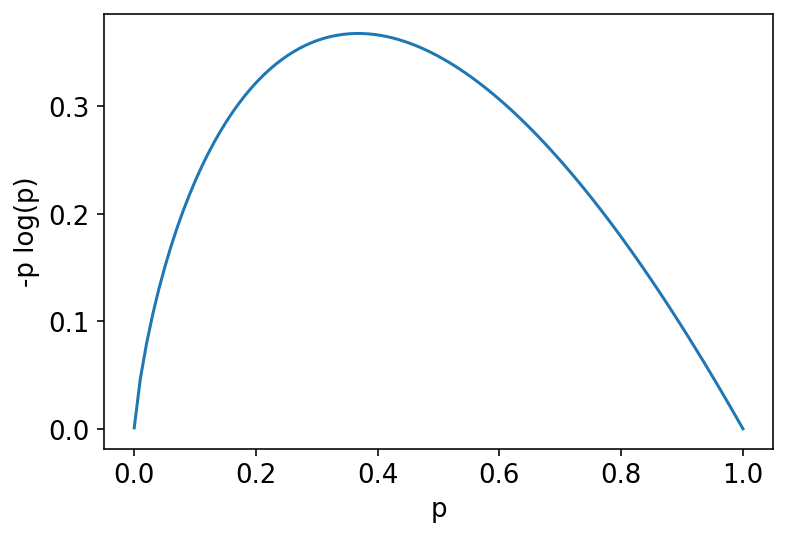

In [3]:
## 확률 p와 엔트로피 보기

xs = np.linspace(0.0001, 1, 100)
plt.plot(xs, -xs*np.log(xs))
plt.xlabel("p")
plt.ylabel("-p log(p)")
plt.show()

### 크로스 엔트로피 

- 분류에서 손실함수, 즉 학습을 하면서 줄여야 할 대상 값은 크로스 엔트로피를 사용한다
- 분류가 잘 수행될수록 (즉, 분류된 하위 그룹의 p가 1 또는 0으로 수렴할수록) 크로스 엔트로피의 합은 점차 줄어들며 이를 분류의 손실함수로 사용한다
- 계산량을 줄이기 위해서 크로스 엔트로피 대신 gini 계수를 주로 사용한다 (디폴트 값)

<img  src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.13.11.png?raw=1" align='left'  width=400>

- 크로스 엔트로피: 

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%208.29.58.png?raw=1" align='left'  width=150>

- gini 계수: 계산량을 줄이기 위해서 크로스 엔트로피 대신 지니 계수를 주로 사용한다

$1 - \sum {p_{i}}^2$

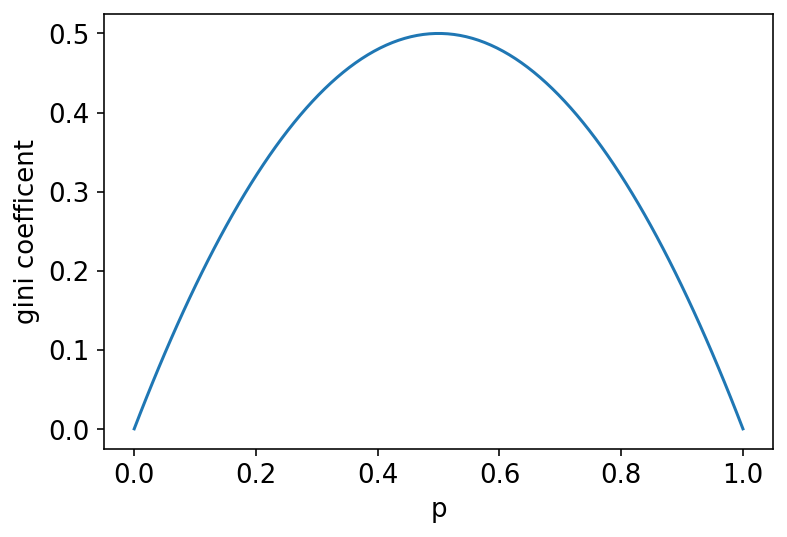

In [4]:
## 확률 p와 (1-p)의 지니 계수 보기

xs = np.linspace(0, 1, 100)
plt.plot(xs, 1-(xs**2 + (1-xs)**2))
plt.xlabel("p")
plt.ylabel("gini coefficent")
plt.show()

In [5]:
## 분류 작업 후 지니 계수 합 구하기

# 지니 계수를 구하는 함수
def gini_index(a,b):
    p = a/(a+b)
    q = 1 - p
    return np.round((1-p**2 - q**2),3)

# 분류기 (a)의 지니 계수 합 구하기
print(gini_index(9,2), gini_index(3,6))
print('(a) 지니 계수의 합 = ',gini_index(9,2)+gini_index(3,6))

# 분류기 (b)의 지니 계수 합 구하기
print(gini_index(10,1), gini_index(2,7))
print('(b) 지니 계수의 합 = ',gini_index(10,1)+gini_index(2,7))

0.298 0.444
(a) 지니 계수의 합 =  0.742
0.165 0.346
(b) 지니 계수의 합 =  0.511


In [6]:
gini_index(409,257)

0.474

## 타이타닉 생존 여부 예측

- Survival - 생존여부(타겟변수 y): 0 = No, 1 = Yes
- Pclass - 티켓 등급: 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex - 성별: male, female
- Age - 나이
- SibSp - 동승한 형제, 배우자 수
- Parch - 부모와 자녀의 수
- Ticket - 티켓 번호
- Fare - 승선 요금
- Cabin - 캐빈(객실) 번호
- Embarked - 승선한 항구: C = Cherbourg, Q = Queenstown, S = Southampton

## import

In [16]:
## 데이터 전처리 전과정 실행

# 데이터 다운로드하기
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/titanic_train.csv")
# df = pd.read_csv("titanic_train.csv")

# 나이 결측치를 평균 나이로 대체 (대체한 것을 즉시 반영했다)
df.Age.fillna(df.Age.mean(), inplace=True)

# Embarked (항구명) 결측치가 있는 두 샘플은 삭제한다
df = df[~df["Embarked"].isnull()]

# 사용하지 않을 컬럼 4개를 삭제한 데이터프레임을 만들고 백업한다
df = df[df.columns.difference(['PassengerId','Name','Ticket','Cabin'])]

# 선실등급, 성별, 항구명을 원핫 인코딩한다
df = pd.get_dummies(df, columns=['Pclass','Sex','Embarked'])

# 요금(Fare)은 로그를 취한 값을 사용한다
df["Fare"] = np.log(df.Fare +1)

# 연속형 변수에 표준 스케일링을 적용한다
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df.loc[:][['Age','Fare','SibSp','Parch']] = scaler.fit_transform(df[['Age','Fare','SibSp','Parch']])

# 데이터분석에 사용할 X와 y 얻기
X = df[df.columns.difference(['Survived'])]
y = df.Survived

# X, y 크기 확인하기
print(X.shape, y.shape)

(889, 12) (889,)



## 데이터 전처리 종류

- 데이터 클리닝 - 결측치 처리, 틀린값 처리
- 스케일링 - 여러 변수 값의 범위를 동등한 조건으로 맞추는 것: 표준 스케일링, min-max 스케일링
- 이상치 처리 - 이상치 탐지 및 제거
- 데이터 변환 - 로그 변환, 카테고리 인코딩 등

# 선형 분류 예측

In [17]:
## 선형 이진 분류 수행

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8, shuffle=True)

In [18]:
## 선형 분류 모델로 SGDClassifier를 사용
lin = SGDClassifier()

# 학습 데이터를 사용하여 학습을 수행한다
lin.fit(X_train, y_train)

# 검증 데이터를 사용하여 모델의 성능을 확인한다 (정확도를 알려준다)
lin.score(X_test, y_test)

0.6771300448430493

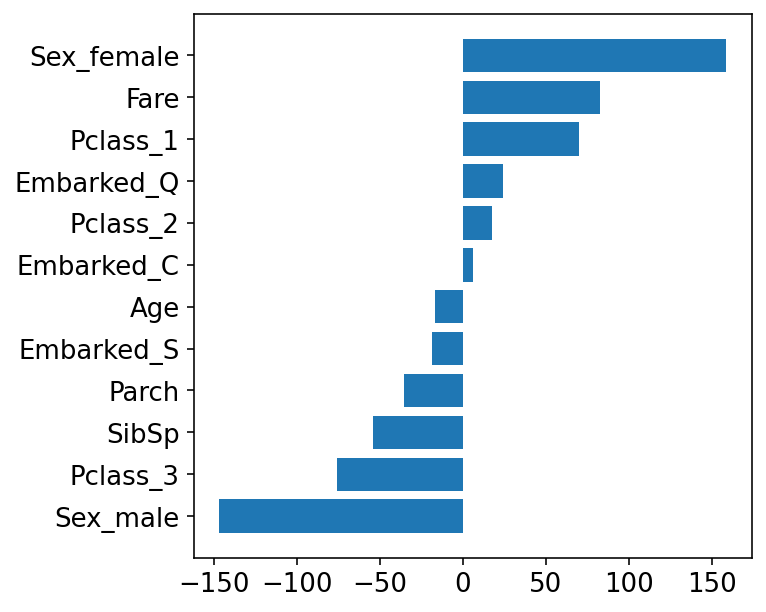

In [19]:
## 선형 모델 가중치 보기

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(5,5))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

plot_feature_weight(X.columns, lin.coef_[0])

- 위 결과를 보면 생존하는데 가장 많이 기여한 변수는 여성, 요금, 1등석 등이고
- 생존하지 않는데 가장 많이 기여한 변수는 남성, 나이, 3등객실 등인 것을 알 수 있다

# 결정트리

- 결정 트리를 회귀모델에 사용할 때는 나누어지는 하위 두 그룹의 분산이 가능한 작아지도록 나눈다
 - 즉, 회귀 대상의 수치가 가능한 비슷한 샘플들이 모이도록 나눈다
- 결정 트리를 분류에 사용할 때는 크로스엔트로피 (또는 지니지수)가 가능한 작아지도록 나눈다
 - 즉, 나누어진 그룹에 같은 그룹의 샘플이 모이는 것을 측정하여 순도(purity)가 가능한 높아지도록 나눈다


## 손실함수로 엔트로피 사용

### 엔트로피

- 확률 p인 사건의 가치:  $log$(${1}\over{p}$) 
- 엔트로피=확률x기대치: $Entropy(H)$ = $p$ $log$(${1}\over{p}$)



## 결정 트리를 이용한 이진 분류

In [20]:
## 결정 트리를 이용한 이진 분류

# 최적의 트리 깊이 (max_depth)를 실험으로 찾는다
for depth in range(1,10):
    dtc = DecisionTreeClassifier(max_depth=depth) 
    dtc.fit(X_train, y_train) 
    print(depth, dtc.score(X_test, y_test).round(3)) 

1 0.794
2 0.762
3 0.812
4 0.812
5 0.807
6 0.776
7 0.735
8 0.749
9 0.713


0.812


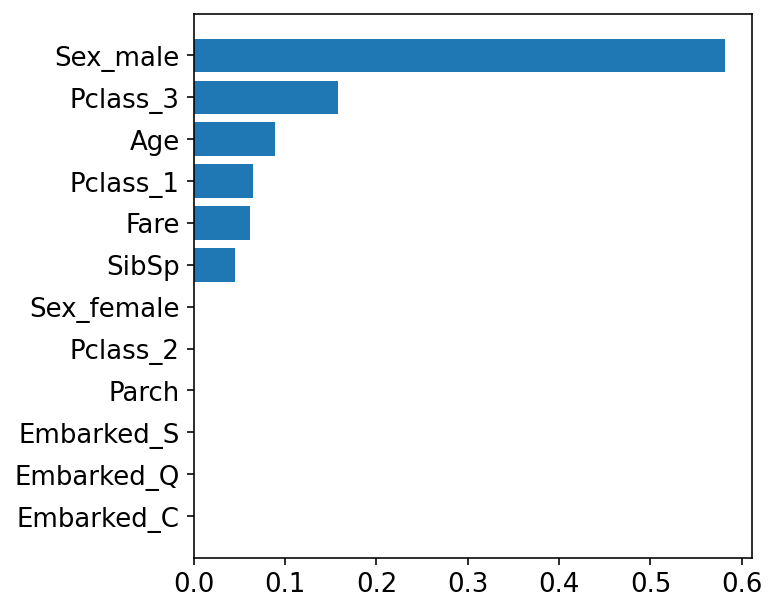

In [21]:
## 최적의 트리 깊이 max_depth=3

dtc = DecisionTreeClassifier(max_depth=3) 
dtc.fit(X_train, y_train) 
print(dtc.score(X_test, y_test).round(3)) 

plot_feature_weight(X.columns, dtc.feature_importances_)

In [22]:
## 혼돈 매트릭스와 분류 평가 보기

def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

y_pred = dtc.predict(X_test)
show_clf_result(y_test, y_pred)

[[120  20]
 [ 22  61]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       140
           1       0.75      0.73      0.74        83

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



In [25]:
# 선형모델에서는 decision_function()을 호출하여 scores를 구했었다. -11 ~ 14 (남녀구분의 경우)
# 경계치를 높이면 정밀도가 올라가고, 낮추면 리콜이 올라가는 모델을 확보할수 있었다.
# 기타 다른 모델은 분류 확률을 알려준다. 이를 이용해서 
#     p > 0.5 기본모델
#     p > 0.9 정밀도를 높인 모델
#     p > 0.2 리콜이 높은 모델을 얻는다.
# 앞에는 0일 확률, 뒤에는 1(생존)일 확률
dtc.predict_proba(X_test)[:5]

array([[0.62068966, 0.37931034],
       [0.89197531, 0.10802469],
       [0.04      , 0.96      ],
       [0.89197531, 0.10802469],
       [0.04      , 0.96      ]])

In [27]:
## 검증 데이터 샘플의 생존 확률 보기

X_proba = X_test.copy()
X_proba['proba'] = dtc.predict_proba(X_test)[:,1]
X_proba[:5]

,Age,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp,proba
35,42.000000,0,0,1,3.970292,0,1,0,0,0,1,1,0.379310
563,29.699118,0,0,1,2.202765,0,0,0,1,0,1,0,0.108025
496,54.000000,1,0,0,4.372818,0,1,0,0,1,0,1,0.960000
371,18.000000,0,0,1,2.014343,0,0,0,1,0,1,1,0.108025
306,29.699118,1,0,0,4.717456,0,1,0,0,1,0,0,0.960000


In [28]:
## 생존으로 분류할 클래스 확률 보기

dtc.predict_proba(X_test)[:,1][:10].round(3)

array([0.379, 0.108, 0.96 , 0.108, 0.96 , 0.96 , 0.108, 0.379, 0.108,
       0.96 ])

## 결정 트리 보기

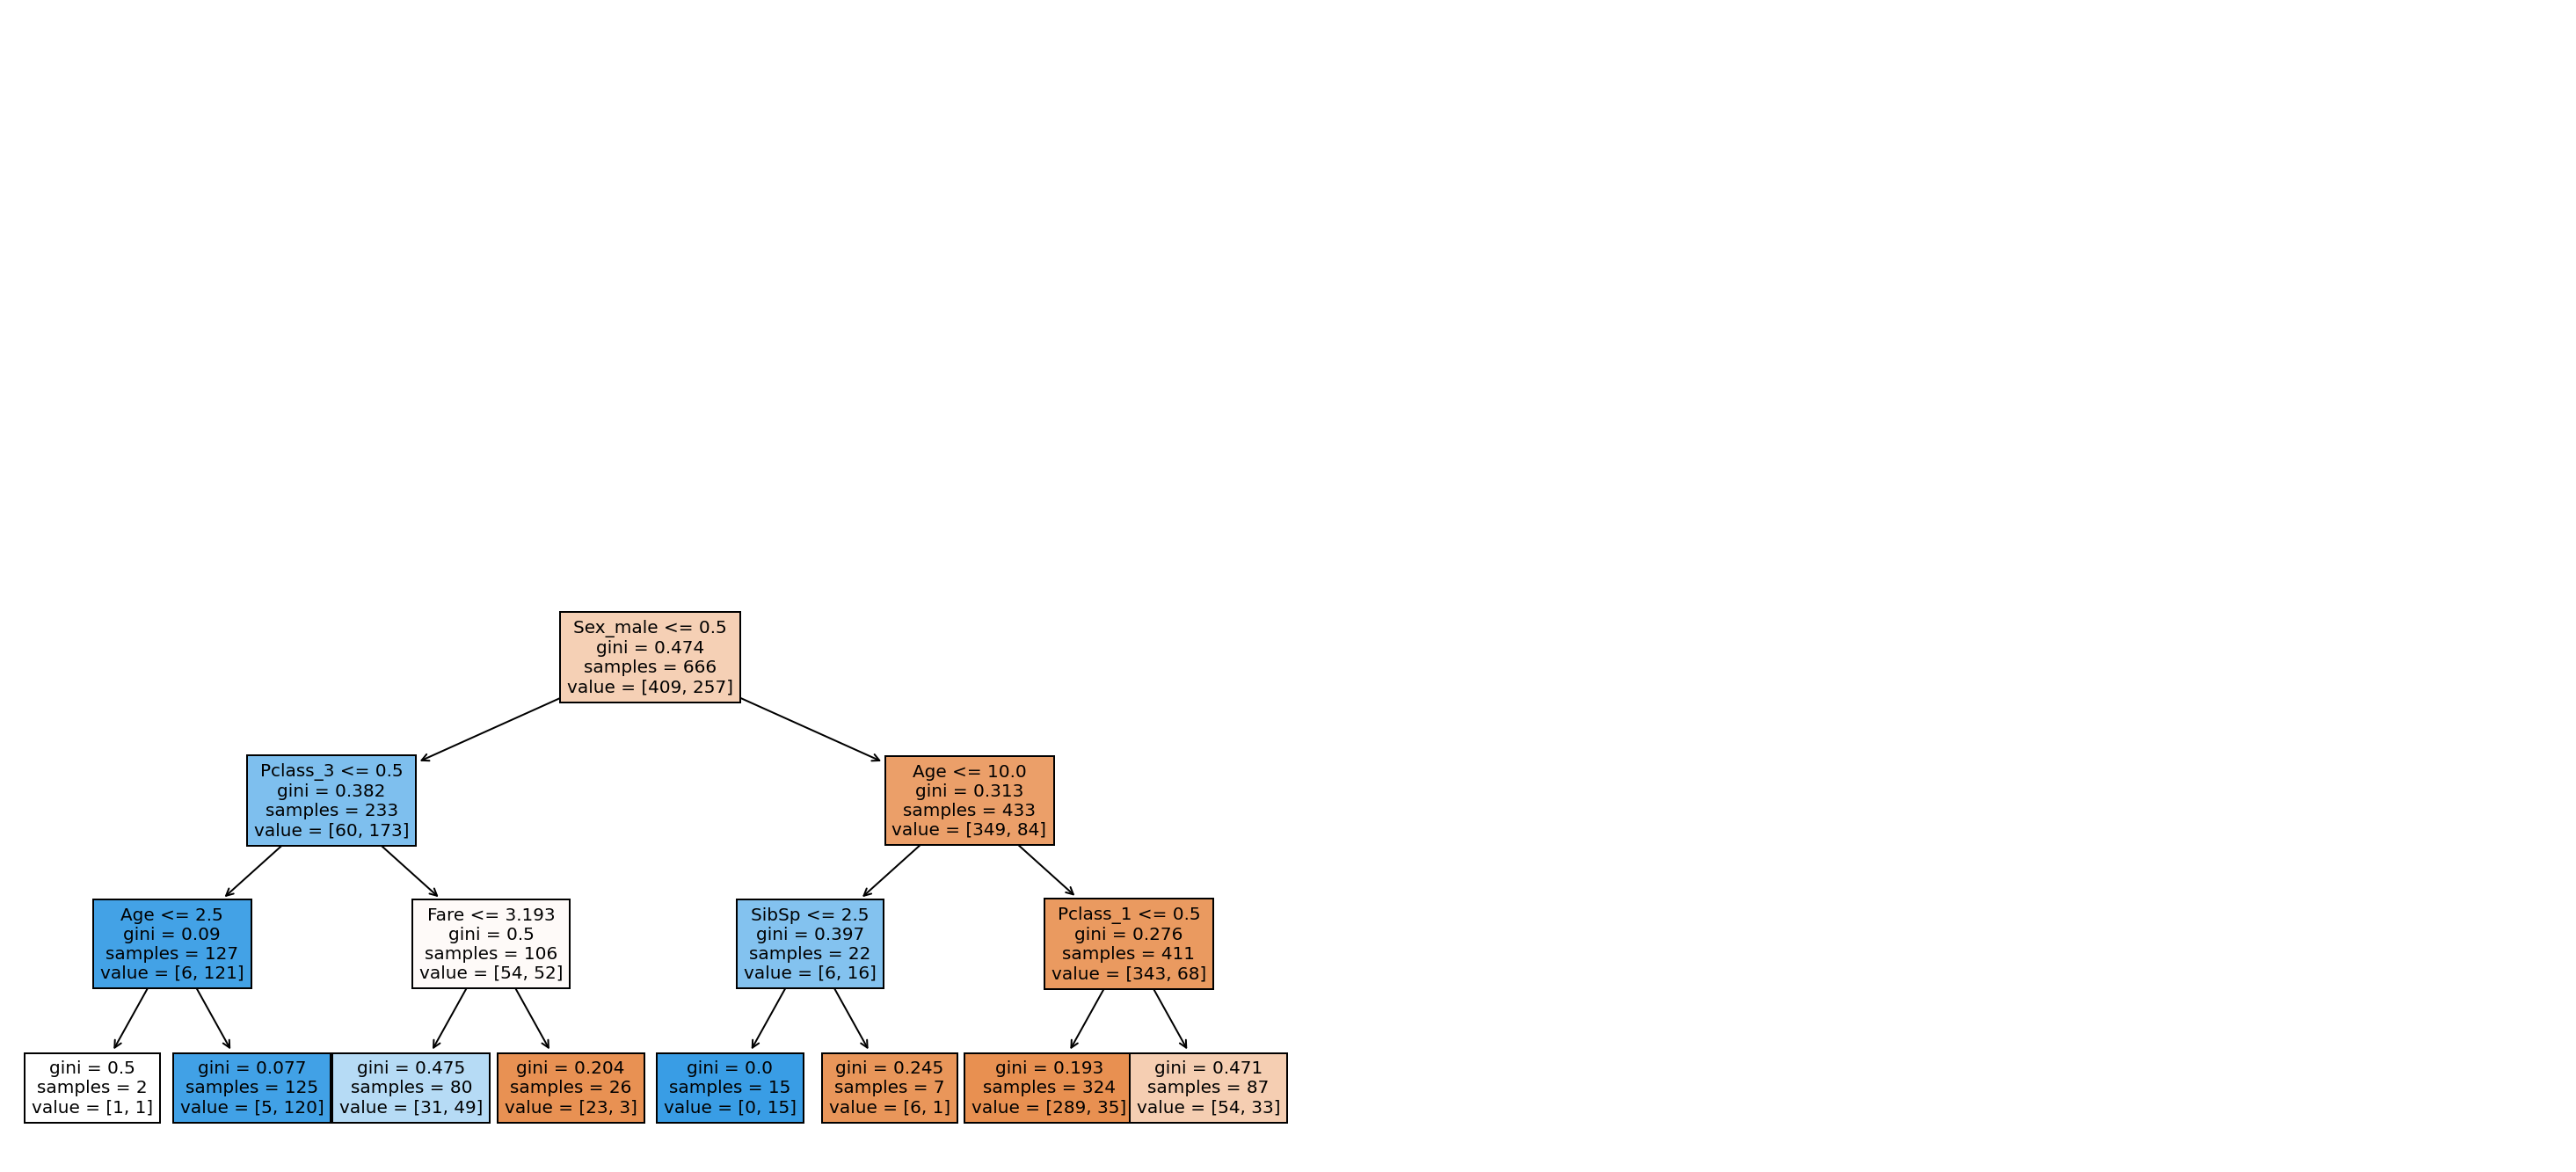

In [32]:
## 결정 트리 보기 (2단까지만 보기)

from sklearn import tree
import matplotlib
plt.figure(figsize=(26,12))

tree.plot_tree(dtc, fontsize=10,
              feature_names=X.columns,
              filled=True,
#             impurity=True,
              max_depth=3)
plt.show()

# 랜덤 포레스트


- 결정 트리의 성능을 개선한 방법
- 간단한 구조의 결정 트리(weak learner)를 수십~수백개를 만들고 각 결정 트리의 동작 결과의 평균치를 구하는 방법
- 앙상블(ensemble) 방법이 하나의 모델만 만드는 것보다 좋은 성능을 보인다
- 각 결정 트리를 만들 때 훈련 데이터의 일부만 사용하거나 특성의 일부를 무작위로 선택하여 만든다 

- 랜덤 포레스트 개념

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.13.52.png?raw=1" align='left'  width=600>

- 소프트 투표

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.52.18.png?raw=1" align='left'  width=600>

In [33]:
## 랜덤 포레스트를 이용한 이진 분류

# 최적의 트리 깊이(max_depth)를 실험으로 찾는다
for depth in range(1,10):
    rfc = RandomForestClassifier(max_depth=depth)
    rfc.fit(X_train, y_train) 
    print(depth,rfc.score(X_test, y_test).round(4))

1 0.7937
2 0.7937
3 0.7982
4 0.8161
5 0.8206
6 0.8027
7 0.7892
8 0.7937
9 0.7848


In [34]:
## 최적의 모델 (max_depth=5)

rfc = RandomForestClassifier(max_depth=5)
rfc.fit(X_train, y_train) 
print(rfc.score(X_test, y_test).round(4))

# 혼돈 매트릭스와 분류 평가 보기
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

0.8206
[[122  18]
 [ 22  61]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       140
           1       0.77      0.73      0.75        83

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



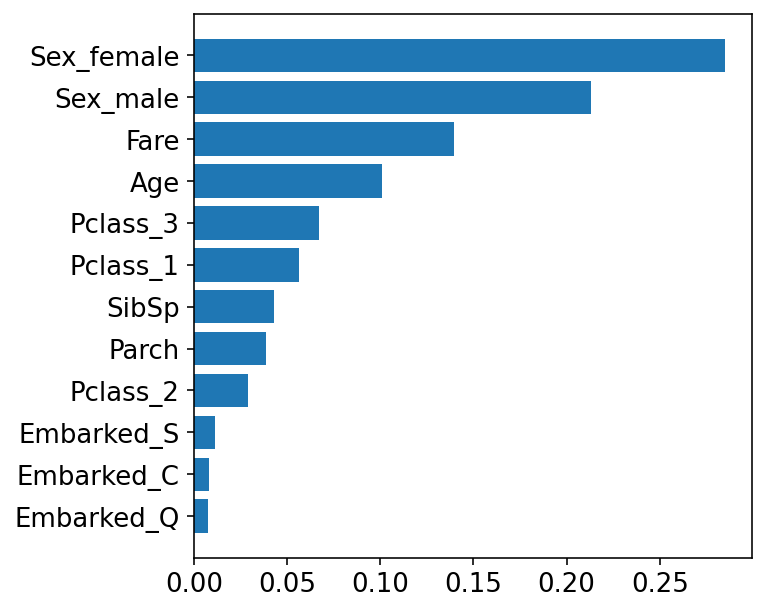

In [35]:
## 특성 중요도 (feature_importances_ 보기)

plot_feature_weight(X.columns, rfc.feature_importances_)

# 부스팅 (LightGBM)

In [36]:
## 최적의 모델 찾기 (max_depth)

for depth in range(1,10):
    lgbm_c = LGBMClassifier(max_depth=depth,num_leaves=64)
    lgbm_c.fit(X_train, y_train)
    print(depth, lgbm_c.score(X_test, y_test).round(4))

1 0.8117
2 0.8161
3 0.8027
4 0.8206
5 0.8206
6 0.8161
7 0.7982
8 0.7892
9 0.8117


In [37]:
## 최적의 모델 (max_depth=4)

lgbm_c = LGBMClassifier(max_depth=4)
lgbm_c.fit(X_train, y_train)
lgbm_c.score(X_test, y_test)

0.820627802690583

In [38]:
## 혼돈 매트릭스와 분류 평가 보기

y_pred = lgbm_c.predict(X_test)
show_clf_result(y_test, y_pred)

[[122  18]
 [ 22  61]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       140
           1       0.77      0.73      0.75        83

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



In [39]:
## 클래스 분류 확률 (1이라고 분류할 확률)

proba = lgbm_c.predict_proba(X_test)[:,1]
proba[:5]

array([0.31989292, 0.13478204, 0.9843518 , 0.04289308, 0.99297317])

In [40]:
## 높은 정밀도를 갖는 예측 모델을 만들려면 경계값을 높인다

proba = lgbm_c.predict_proba(X_test)[:,1]
y_pred_high_precision = proba > 0.7
show_clf_result(y_test, y_pred_high_precision)

[[130  10]
 [ 36  47]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       140
           1       0.82      0.57      0.67        83

    accuracy                           0.79       223
   macro avg       0.80      0.75      0.76       223
weighted avg       0.80      0.79      0.78       223



In [41]:
## 높은 재현율을 갖는 예측 모델을 만들려면 경계값을 낮춘다

y_pred_high_recall = proba > 0.3
show_clf_result(y_test, y_pred_high_recall)

[[101  39]
 [ 14  69]]
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       140
           1       0.64      0.83      0.72        83

    accuracy                           0.76       223
   macro avg       0.76      0.78      0.76       223
weighted avg       0.79      0.76      0.77       223



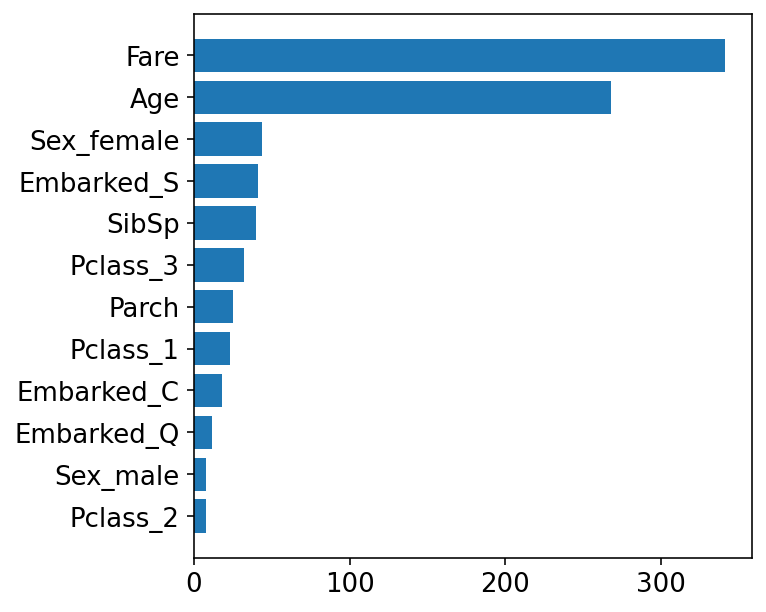

In [42]:
## 특성 중요도 (feature_importances_ 보기)

plot_feature_weight(X.columns, lgbm_c.feature_importances_)